In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import ast

from sys import path
path.insert(0, "lib")
from lib.onedmodel import *
from pathlib import Path

In [2]:
# Plotting settings
plt.style.use('ggplot')
fig_width = 25  # figure width in cm
inches_per_cm = 0.393701               # Convert cm to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width*inches_per_cm  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
label_size = 14
tick_size = 12
params = {'backend': 'ps',
          'lines.linewidth': 1.5,
          'axes.labelsize': label_size,
          'axes.titlesize': label_size,
          'font.size': label_size,
          'legend.fontsize': tick_size,
          'xtick.labelsize': tick_size,
          'ytick.labelsize': tick_size,
          'text.usetex': False,
          'figure.figsize': fig_size,
          "font.weight": "bold",
          "axes.labelweight": "bold"}
plt.rcParams.update(params)

In [3]:
def is_literal_eval_successful(s):
    try:
        ast.literal_eval(s)
        return True
    except ValueError:
        return False
    
def read_clean_trajectories(fpath: Path):
    """
    Filter exploding trajectories and convert strings into array of trajectories
    """
    df = pd.read_csv(fpath)
    df = df[df['trajectory'].apply(is_literal_eval_successful)]
    df['trajectory'] = df['trajectory'].apply(ast.literal_eval)
    trajectories = np.asarray(df['trajectory'].to_list())
    clean_traj = trajectories[~np.isnan(trajectories).any(axis=1)]
    return clean_traj

Plot fraction of trajectories

In [32]:
nSGD = 10**3
nsamples = 10**3
shuffle = True
batch_size= 20
w0 = 1.7
seed_init = 1
seed_data = 1
wmin = -2.0
wmax = -1
model = PolyModel(w0=w0, seed=seed_init, wmin=wmin, wmax=wmax)
sgd_runner = SGDPolyRunner(nSGD=nSGD, nsamples=nsamples, seed=seed_data, shuffle=shuffle, 
                           batch_size=batch_size, auto=True)
df = sgd_runner.generate_trajectories(model)

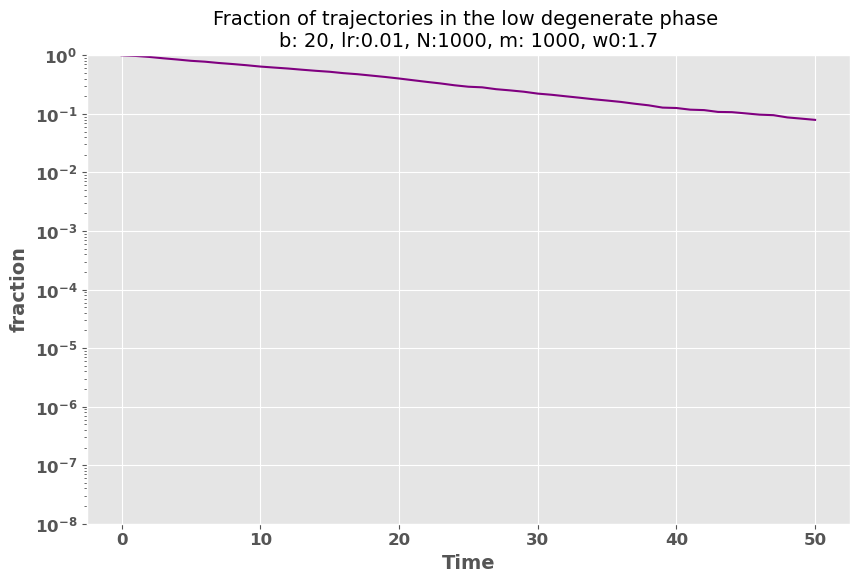

In [33]:
%matplotlib inline
ymin = 1e-8
trajectories = df["trajectory"].to_list()
trajectories = np.asarray(trajectories)
fraction = regular_fraction(trajectories, model)
nit = len(fraction)
time = np.arange(0, nit,1)
plt.plot(time, fraction[time], color="purple")
plt.xlabel("Time")
plt.ylabel("fraction")
plt.yscale("log")
plt.title("Fraction of trajectories in the low degenerate phase \n" 
            f"b: {sgd_runner.batch_size}, lr:{sgd_runner.lr}, N:{sgd_runner.nSGD}, m: {sgd_runner.nsamples}, w0:{model.w0}")
plt.ylim((ymin,1))
plt.show()

# Compute escape rate

In [13]:
# Linear regress fraction against time 
from scipy.stats import linregress
def compute_escape_rate(fraction, frac_max = 10**-2):
    itmax = np.argmax(fraction<frac_max)
    time = np.arange(0, itmax,1)
    log_frac = np.log(fraction[:itmax])
    stats = linregress(time, log_frac)
    return stats

LinregressResult(slope=-0.3666819236567633, intercept=0.2773013063412304, rvalue=-0.9688884907587398, pvalue=5.1551086957581524e-08, stderr=0.028241675677196185, intercept_stderr=0.19969880383416605)


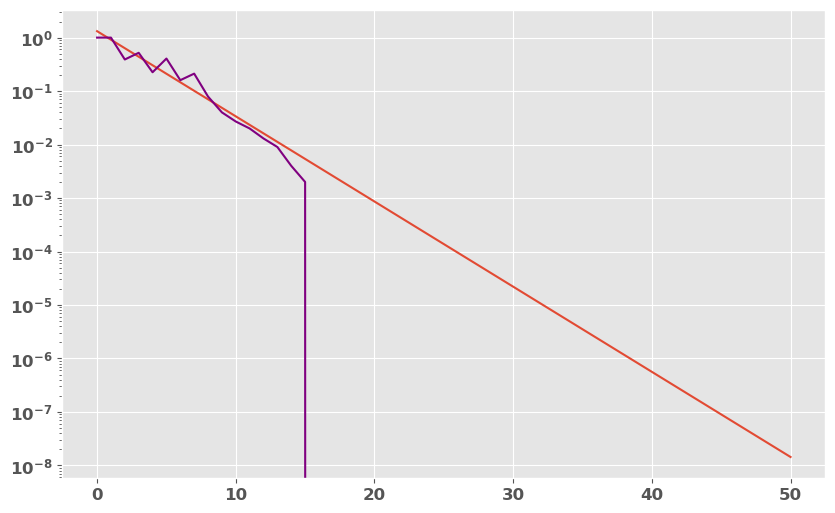

In [14]:
stats = compute_escape_rate(fraction)
print(stats)
y = stats.slope * time + stats.intercept
plt.plot(time, np.exp(y))
plt.plot(time, fraction[time], color="purple")
plt.yscale("log")

Experiment 0 over 20
Experiment 10 over 20


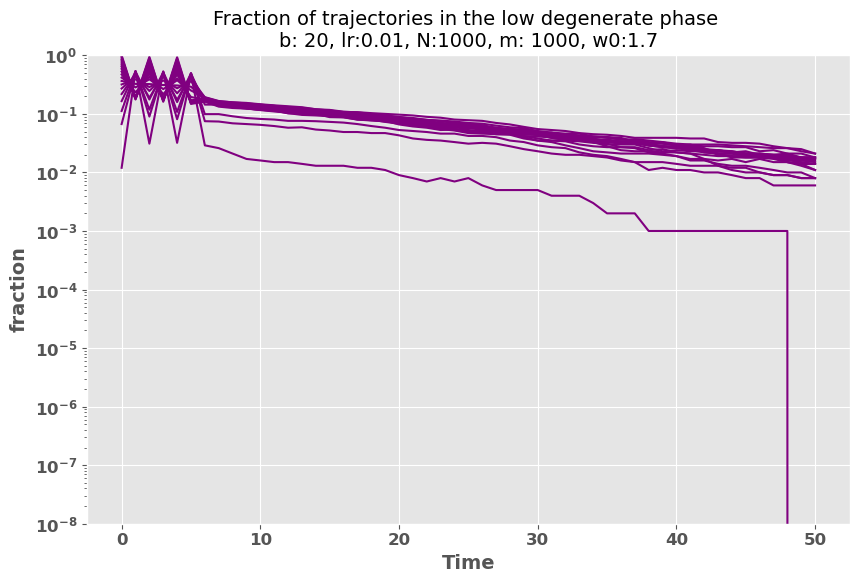

In [34]:
# Vary initialisation to compute escape rate
wbarrier = (model.w0*model.d1 - model.w0*model.d2)/(model.d1 + model.d2)
nexp = 20
window_size = 
escape_rate = []
ymin = 1e-8
wmins = np.linspace(wbarrier - window_size, wbarrier - 0.1, nexp)
wmaxs = np.linspace(wbarrier, wbarrier + window_size, nexp)
for i in range(nexp):
    if i%10 == 0:
        print(f"Experiment {i} over {nexp}")
    wmin = wmins[i]
    wmax = wmaxs[i]
    model = PolyModel(w0=w0, seed=seed_init, wmin=wmin, wmax=wmax)
    sgd_runner = SGDPolyRunner(nSGD=nSGD, nsamples=nsamples, seed=seed_data, shuffle=shuffle, 
                            batch_size=batch_size, auto=True)
    df = sgd_runner.generate_trajectories(model)
    trajectories = df["trajectory"].to_list()
    trajectories = np.asarray(trajectories)
    fraction = regular_fraction(trajectories, model)
    nit = len(fraction)
    time = np.arange(0, nit,1)
    plt.plot(time, fraction[time], color="purple")
plt.xlabel("Time")
plt.ylabel("fraction")
plt.yscale("log")
plt.title("Fraction of trajectories in the low degenerate phase \n" 
            f"b: {sgd_runner.batch_size}, lr:{sgd_runner.lr}, N:{sgd_runner.nSGD}, m: {sgd_runner.nsamples}, w0:{model.w0}")
plt.ylim((ymin,1))
plt.show()


Text(0.5, 1.0, 'Escape rate along sliding window \nb: 20, lr:0.01, N:1000, m: 1000, w0:2 \nwindow size 8, min boundary from -8.666666666666666 to -0.7666666666666666')

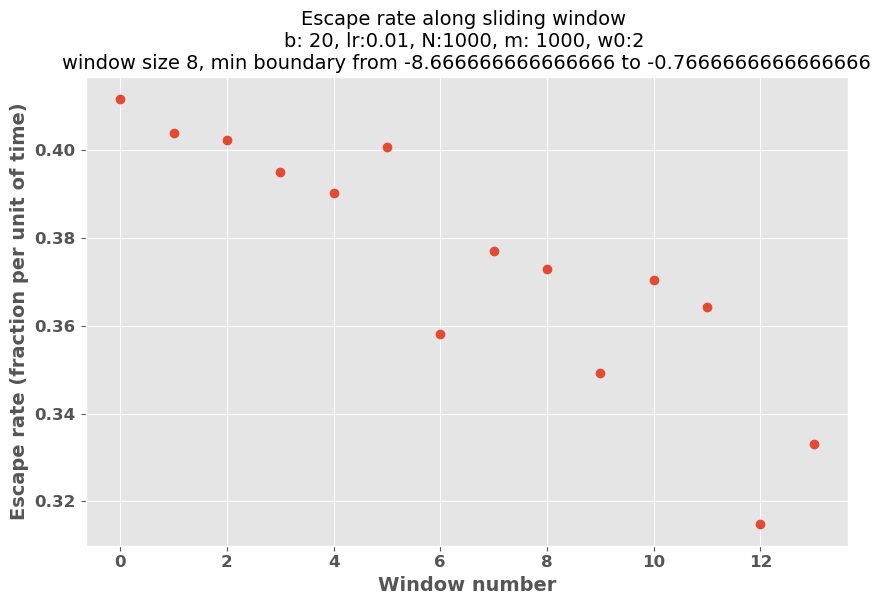

In [30]:
x = np.arange(0, len(escape_rate))
plt.plot(x, escape_rate, 'o')
plt.ylabel("Escape rate (fraction per unit of time)")
plt.xlabel("Window number")
plt.title("Escape rate along sliding window \n" 
            f"b: {sgd_runner.batch_size}, lr:{sgd_runner.lr}, N:{sgd_runner.nSGD}, m: {sgd_runner.nsamples}, w0:{model.w0} \n" 
            f"window size {window_size}, min boundary from {wmins[0]} to {wmins[-1]}")

# Look at the influence of hyperparameters

In [5]:
nSGD = 10**3
nsamples = 10**3
shuffle = True
seed_init = 1
seed_data = 1
w0 = 1
nw0 = 2

model = PolyModel(w0=w0, nw0=nw0, seed=seed_init)
sgd_runner = SGDPolyRunner(nSGD=nSGD, nsamples=nsamples, seed=seed_data, shuffle=shuffle, 
                           auto=True)
w0_range = np.arange(1.3, 2, 0.2)
batch_range = np.arange(5, 40, 5)
lr_range = [0.1, 0.01, 0.001]

sgd_runner.parameter_sweep(w0_range, batch_range, lr_range, model)

Running experiment 0 over 84
trajectory 0 over 1000
The 2-parent path is /Users/guime/projects/sgd_singular/sgd_on_singularities
Running experiment 1 over 84
trajectory 0 over 1000
The 2-parent path is /Users/guime/projects/sgd_singular/sgd_on_singularities
Running experiment 2 over 84
trajectory 0 over 1000


KeyboardInterrupt: 

(0.001, 1)

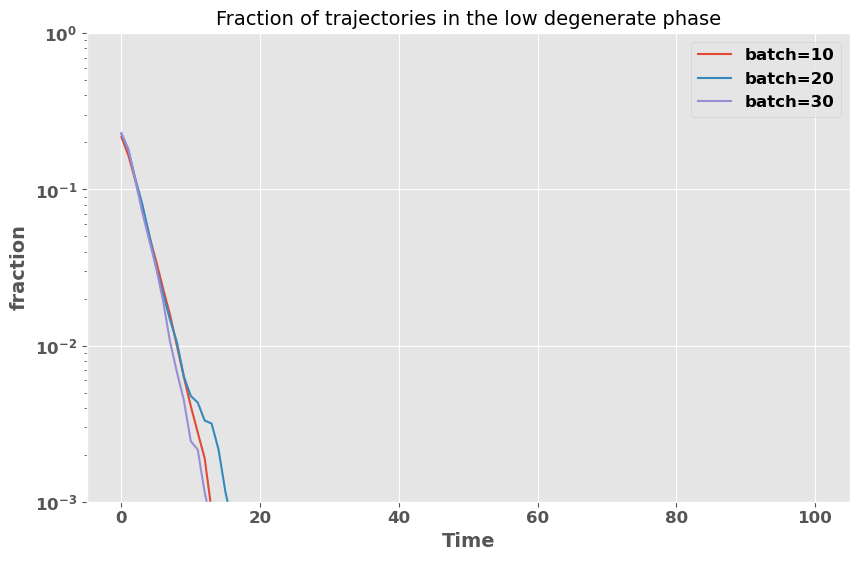

In [12]:
for batch_size in batch_range:
    model = PolyModel(d1=d1, d2=d2, w0=w0, nw0=nw0)
    fpath = Path('../data')
    fname = f"experiment_d1_{d1}_d2_{d2}_w0_{w0}_lr_{lr}_momentum_{momentum}_batch_{batch_size}_niter_{niter}.csv"
    fpath = fpath.joinpath(fname)
    trajectories = read_clean_trajectories(fpath)
    fraction = regular_fraction(trajectories, model)
    nit = len(fraction)
    time = np.arange(0, nit,1)
    plt.plot(time, fraction[time], label = f"batch={batch_size}")
plt.xlabel("Time")
plt.ylabel("fraction")
plt.yscale("log")
plt.legend()
plt.title("Fraction of trajectories in the low degenerate phase")
plt.ylim((0.001,1))

FileNotFoundError: [Errno 2] No such file or directory: '../data/experiment_d1_1_d2_2_w0_2_lr_0.001_momentum_0_batch_20_niter_20.csv'

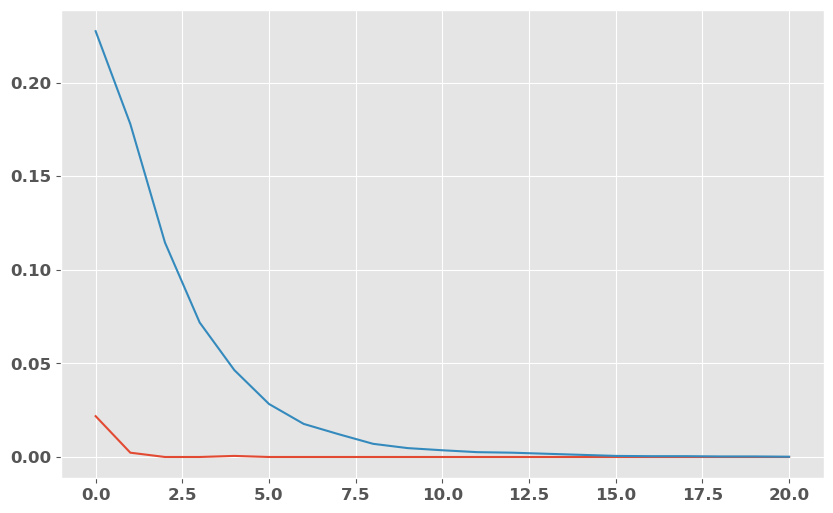

In [16]:
niter = 20
batch_size = 20
for lr in lr_range:
    model = PolyModel(d1=d1, d2=d2, w0=w0, nw0=nw0)
    fpath = Path('../data')
    fname = f"experiment_d1_{d1}_d2_{d2}_w0_{w0}_lr_{lr}_momentum_{momentum}_batch_{batch_size}_niter_{niter}.csv"
    fpath = fpath.joinpath(fname)
    trajectories = read_clean_trajectories(fpath)
    fraction = regular_fraction(trajectories, model)
    nit = len(fraction)
    time = np.arange(0, nit,1)
    plt.plot(time, fraction[time], label = f"lr={lr}")
plt.xlabel("Time")
plt.ylabel("fraction")
plt.yscale("log")
plt.legend()
plt.title("Fraction of trajectories in the low singular phase")
plt.ylim((0.001,1))